In [1]:
import scanpy as sc
import scvi
from matplotlib import rcParams
import matplotlib.pyplot as plt

folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/sc2/"

# Load data

In [2]:
# Read in the data
adata = sc.read(folder_path + "adata_scVI.h5ad")
# model = scvi.model.SCVI.load(folder_path + "model/", adata)
adata

AnnData object with n_obs × n_vars = 150662 × 29566
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'cnv_score'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

# Visualizing UMAP cluster

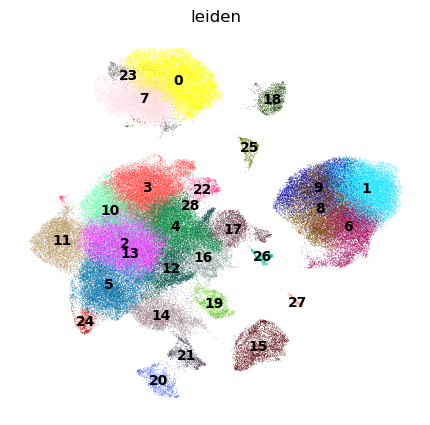

In [3]:
rcParams['figure.figsize'] = (5.3, 5)

sc.pl.umap(
    adata,
    color = ['leiden'],
    frameon = False,
    legend_loc = 'on data',
    # groups = ['21']
)

## Gene expression in feature plot

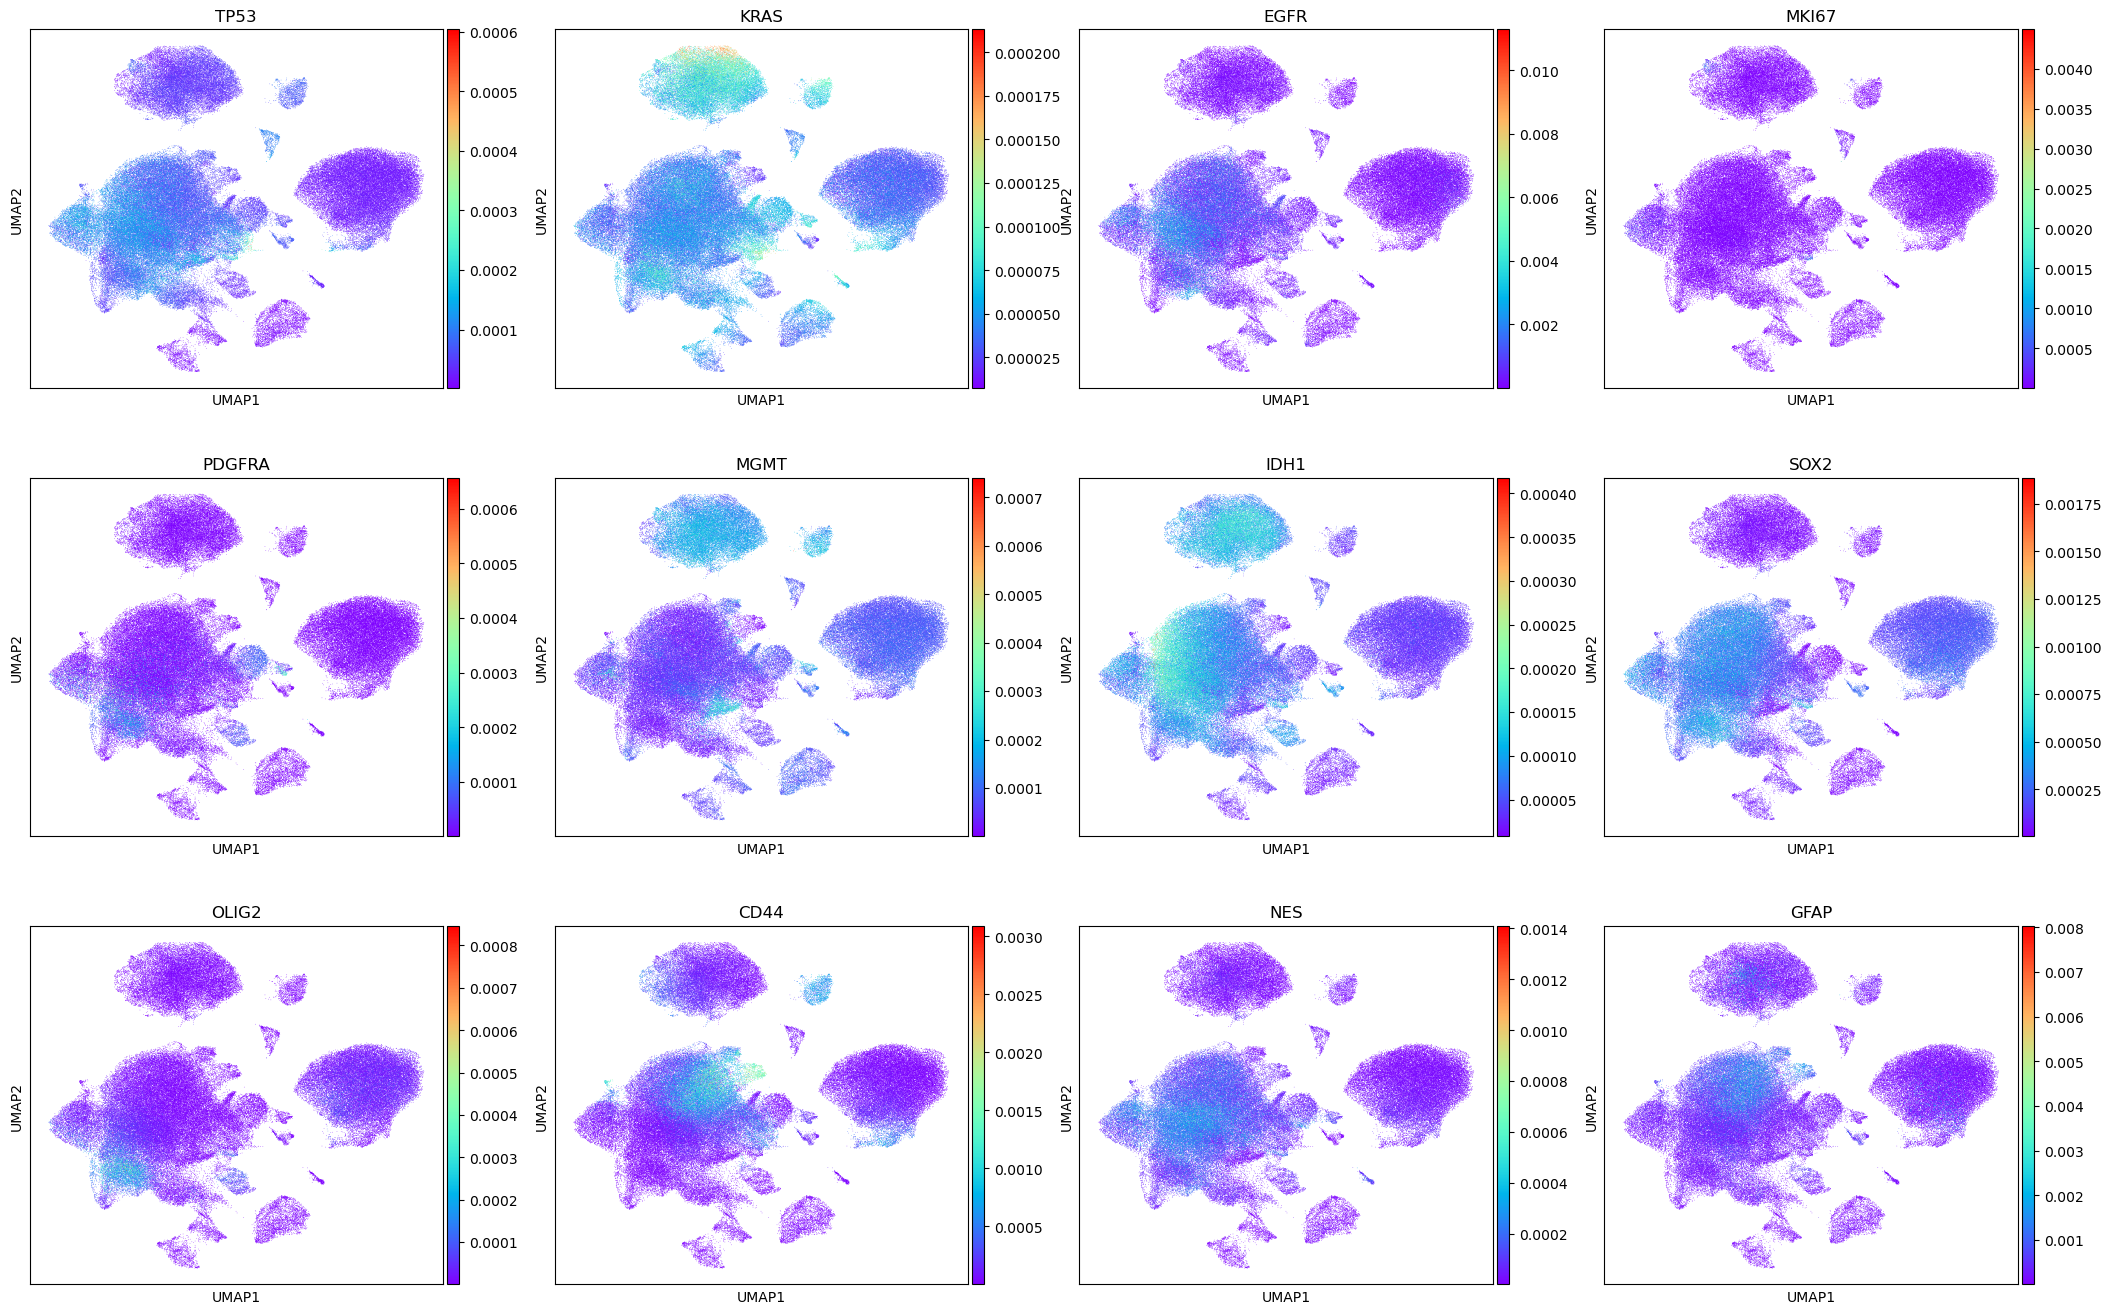

In [4]:
rcParams['figure.figsize'] = (5.5, 5)

sc.pl.umap(
    adata,
    # color = ['gene_set_score'],
    color = ['TP53', 'KRAS', 'EGFR', 'MKI67', 'PDGFRA', 'MGMT', 'IDH1', 'SOX2', 'OLIG2', 'CD44', 'NES', 'GFAP'],
    # color = ['CD3E'],
    # frameon = False,
    layer = 'scvi_normalized',
    color_map = 'rainbow',
)

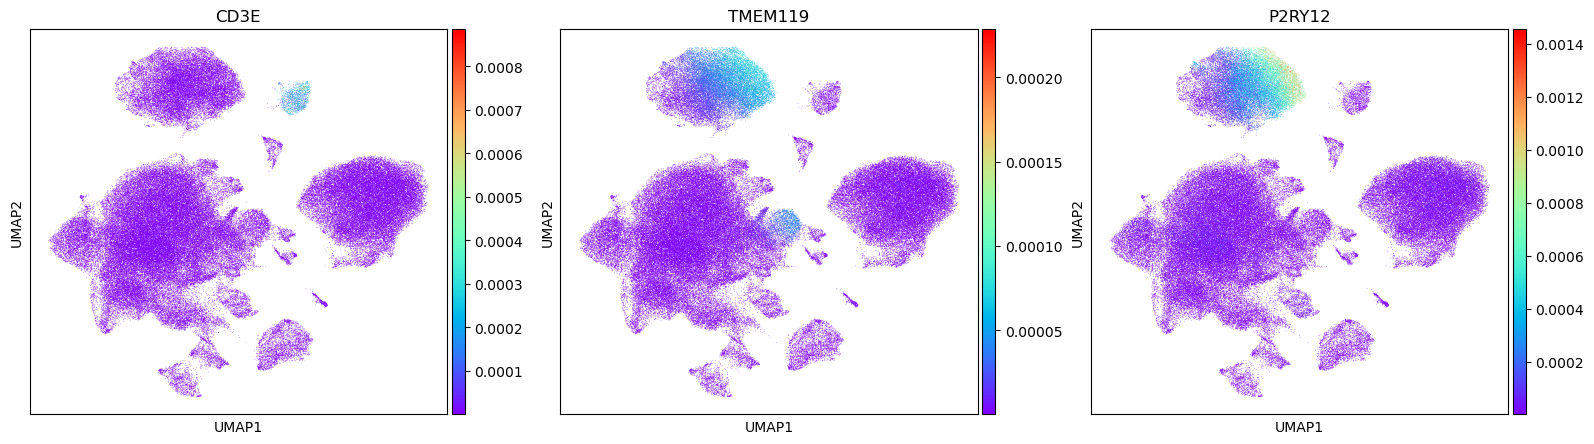

In [5]:
rcParams['figure.figsize'] = (5.5, 5)

sc.pl.umap(
    adata,
    # color = ['gene_set_score'],
    color = ['CD3E', 'TMEM119', 'P2RY12'],
    # frameon = False,
    layer = 'scvi_normalized',
    color_map = 'rainbow',
)

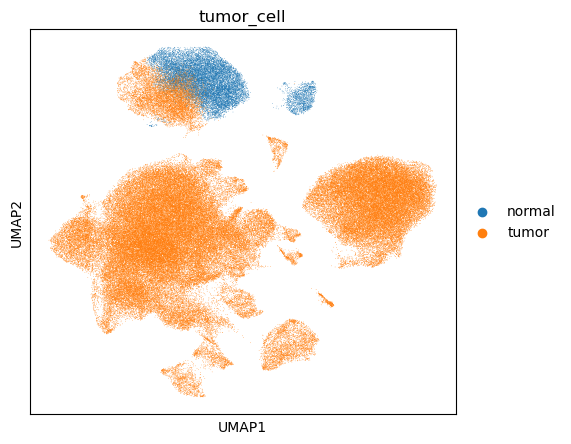

In [6]:
# 가상으로 normal cell을 설정 (확실한 친구들만)
adata.obs['tumor_cell'] = 'tumor'
adata.obs.loc[adata.obs['leiden'] == '18', 'tumor_cell'] = 'normal'  # Monocyte/Microglia
adata.obs.loc[adata.obs['leiden'] == '0', 'tumor_cell'] = 'normal' # Monocyte/Microglia

rcParams['figure.figsize'] = (5.5, 5)

sc.pl.umap(
    adata,
    # color = ['gene_set_score'],
    color = ['tumor_cell'],
    # frameon = False,
)


# InferCNV를 위해 adata.var에 chromosome, start, end column 추가

In [7]:
adata.var.index

Index(['RP11-34P13.3', 'RP11-34P13.7', 'RP11-34P13.14', 'FO538757.3',
       'FO538757.2', 'AP006222.2', 'RP5-857K21.15', 'RP4-669L17.10',
       'RP5-857K21.4', 'RP5-857K21.2',
       ...
       'AC011043.1', 'AC011043.2', 'AL592183.1', 'AC007325.1', 'AC007325.4',
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC004556.1', 'AC240274.1'],
      dtype='object', length=29566)

In [8]:
import pandas as pd

# GTF 파일 경로
gtf_file = 'C:/Users/heung/Dropbox/00. Downloads/gencode.v42.annotation.gtf/gencode.v42.annotation.gtf'

# 파일 로드
gtf = pd.read_csv(
    gtf_file, sep = '\t', comment = '#', header = None,
    names = ['chromosome', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
)

# gene feature만 선택
gtf = gtf[gtf['feature'] == 'gene']

# attribute column에서 gene_id 및 gene_name 추출
gtf['gene_id'] = gtf['attribute'].str.extract('gene_id "([^"]+)"')
gtf['gene_name'] = gtf['attribute'].str.extract('gene_name "([^"]+)"')

# 필요한 열 선택
gtf = gtf[['chromosome', 'start', 'end', 'gene_name']]

# gene_name을 인덱스로 설정
gtf.set_index('gene_name', inplace = True)

In [9]:
# gtf에서 중복된 index 제거
duplicates = gtf.index[gtf.index.duplicated()].unique()
gtf = gtf[~gtf.index.duplicated(keep = 'first')]

# 공통된 gene만 선택
common_genes = gtf.index.intersection(adata.var.index)
filtered_gtf = gtf.loc[common_genes]
adata = adata[:, common_genes]

In [10]:
# 두 개가 같아야 함.
print(len(adata.var.index))
print(len(filtered_gtf.index))

18926
18926


In [11]:
gtf.head()

,chromosome,start,end
gene_name,,,
DDX11L2,chr1,11869,14409
DDX11L1,chr1,12010,13670
WASH7P,chr1,14404,29570
MIR6859-1,chr1,17369,17436
MIR1302-2HG,chr1,29554,31109


In [12]:
# gtf 정보와 adata.var 병합
adata.var = pd.merge(filtered_gtf, adata.var, how = 'inner', left_index = True, right_index = True)

# 필요한 열 확인
# adata.var.head()

# run time: 14m 20s

In [13]:
adata.var.head()

,chromosome,start,end,n_cells
FAM87B,chr1,817371,819837,116
FAM41C,chr1,868071,876903,72
SAMD11,chr1,923923,944575,1459
NOC2L,chr1,944203,959309,11047
KLHL17,chr1,960584,965719,2172


In [14]:
import infercnvpy as cnv

cnv.tl.infercnv(
    adata = adata,
    reference_key = 'tumor_cell',
    reference_cat = 'normal',
    window_size = 100,
)

# run time: 48s

  0%|          | 0/31 [00:00<?, ?it/s]

In [15]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

# run time: 2m 31s

c:\Users\heung\anaconda3\Lib\site-packages\infercnvpy\tl\__init__.py:24: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return sc.tl.leiden(


In [ ]:
cnv.pl.chromosome_heatmap(adata, groupby = 'cnv_leiden', dendrogram = True)

# run time: 18.7s

In [ ]:
cnv.pl.chromosome_heatmap(adata, groupby = 'leiden', dendrogram = True)

# run time: 

In [16]:
# cnv.tl.umap(adata)
# 램 개많이 씀 -> 9m 30s 후 CPU 씀.
# run time: 11m 30s

cnv.tl.cnv_score(adata) # cnv_leiden이 있어야 계산 가능
# run time: 0.7s

... storing 'chromosome' as categorical


<Axes: title={'center': 'cnv_score'}, xlabel='UMAP1', ylabel='UMAP2'>

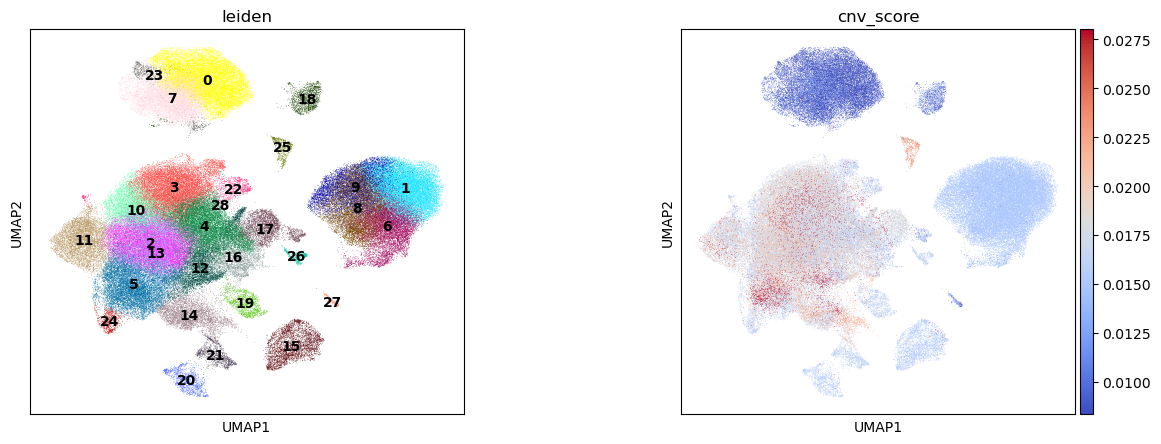

In [17]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"wspace": 0.5})
sc.pl.umap(adata, color="leiden", ax=ax1, show=False, legend_loc = 'on data')
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False, color_map = 'coolwarm')
# sc.pl.umap(adata, color="cell_type", ax=ax3)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


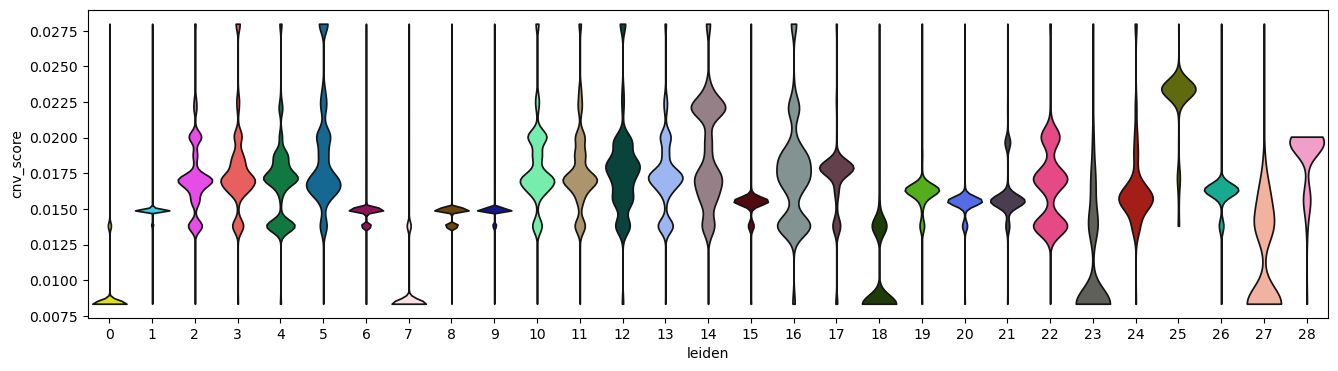

In [18]:
# plot violin plot by cnv_score
fig, ax = plt.subplots(figsize = (16, 4))

sc.pl.violin(
    adata,
    keys = ['cnv_score'],
    groupby = 'leiden',
    stripplot = False,
    # jitter = 0.4,
    # size = 0.3,
    # layer = 'scvi_normalized', use_raw = False,
    ax = ax,
)

In [19]:
cnv_score = adata.obs['cnv_score']

In [20]:
del adata

In [21]:
adata = sc.read(folder_path + "adata_scVI.h5ad")

In [22]:
adata.obs = adata.obs.join(cnv_score, how = 'left')
adata

AnnData object with n_obs × n_vars = 150662 × 29566
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'cnv_score'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [23]:
adata.write_h5ad(folder_path + "adata_scVI.h5ad")